In [1]:
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
f = pyedflib.EdfReader(r"D:\BaiduNetdiskDownload\sz1.edf")
n = f.signals_in_file
signal_labels = f.getSignalLabels()
record = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    record[i, :] = f.readSignal(i)

<class 'numpy.ndarray'>


In [105]:
time_duration = f.file_duration
signal_nums = f.signals_in_file
samples_nums = f.getNSamples()[0]
samples_freq = samples_nums//time_duration # f.getSampleFrequencies()[0]
start_time = f.getStartdatetime()

In [103]:
frequences*time_duration,samples_nums//time_duration

(1320678, 1000)

In [68]:
[[samples_per_second1,time_duration],[samples_per_second2,frequences]]

[[1323.4134134134133, 1322], [1000.0680786686838, 999]]

In [3]:
def Q_P(x,y,bins):
    '''
    x,y 代表两个信号
    bins代表区间
    该函数返回每个区间的Q、P值
    '''
    sxy=pd.DataFrame({'x':x,'y':y})
    sxy=sxy.sort_values(by='x')
    sxy.index=range(len(sxy))
    sxy['bins']=pd.cut(sxy['x'],bins,labels=range(1,len(bins)))
    Q=[]
    P=[]
    for i in range(len(bins)-1):
        Q.append(sxy[sxy.bins==i+1]['y'].mean())
        P.append((bins[i]+bins[i+1])/2) 
    return Q,P

def sx(i,x,P):
    '''
    i的取值范围是[1,len(P)-1]
    '''
    lp=len(P)
    if(i==1):
        if x<=P[1]:
            return 1
        else:
            return 0
    if(i==lp-1):
        if x>P[lp-2]:
            return 1
        else:
            return 0
    if P[i-1]<x<=P[i]:
        return 1
    else:
        return 0
    
def gx(i,x,Q,P):
    '''
    i的取值范围是[1,len(P)-1]
    '''
    k=(Q[i]-Q[i-1])/(P[i]-P[i-1])
    gx=k*(x-P[i-1])+Q[i-1]
    return gx

def fx(x,Q,P):
    '''
    L: the number of bins
    '''
    L=len(P)
    fx=0
    for i in range(L-1):
        fx+=sx(i+1,x,P)*gx(i+1,x,Q,P)
    return fx   

def h2(y,f):
    my=np.mean(y)
    sst=np.sum((y-my)**2)
    sse=np.sum((y-f)**2)
    h2=1-sse/sst
    return h2

In [169]:
def H2(s1,s2,L):
    bins1=np.linspace(np.min(s1),np.max(s1),L)
    Q1,P1=Q_P(s1,s2,bins1)
    f1=[]
    
    for x in s1:
        f1.append(fx(x,Q1,P1))
    f1=np.array(f1)
    h2s1=h2(s2,f1)
    
    bins2=np.linspace(np.min(s2),np.max(s2),L)
    Q2,P2=Q_P(s2,s1,bins2)
    f2=[]
    for x in s2:
        f2.append(fx(x,Q2,P2))
    f2=np.array(f2)
    h2s2=h2(s1,f2)
    
    s_h2 = [h2s1,h2s2]
    #H2=np.array([[0,h2s1],[h2s2,0]])
    #PQ=[[P1,Q1],[P2,Q2]]
    #return H2,PQ
    return s_h2


def H2_xy(sx,sy,L):
    bins = np.linspace(np.min(sx),np.max(sx),L)
    Q,P =Q_P(sx,sy,bins)
    f=[]
    for x in sx:
        f.append(fx(x,Q,P))
    f=np.array(f)
    h2_xy=h2(sy,f)
    #PQ=[P,Q]
    #return h2_xy,PQ
    return h2_xy


def H2_whole(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7):
    '''
    signals：原始信号，numpy矩阵类型（二维矩阵）
    slideWindows:滑动窗口
    duration：信号的持续时间
    '''
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    
    h2_value = []
    lag_value = []
    
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = start_time_window*sampleFreq
        stop_samples = stop_time_window*sampleFreq
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            s1 = signals[si1][start_samples:stop_samples].copy()
            setSignaltoZero([s1]) # 做归0处理
            for si2 in range(si1+1,signals_num):
                s2 = signals[si2][start_samples:stop_samples].copy()
                setSignaltoZero([s2])
                 # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                # 考虑时间延迟
                # 计算x到y
                sample_maxlag = int(maxlag*sampleFreq)
                for tagi in range(sample_maxlag): # x向右移动，符号为正；y向右移动，符号为负
                    #print(start_samples,stop_samples)
                    s1m = signals[si1][start_samples+tagi:stop_samples+tagi].copy()
                    s2m = signals[si2][start_samples+tagi:stop_samples+tagi].copy()
                    setSignaltoZero([s1m,s2m],1)  # 做归0处理
                    
                    h2_mn = H2(s1m,s2,L) # s1向右移
                    h2_nm = H2(s1,s2m,L) # s2向右移
                    
                    if (h2_mn[0]>two_signals_h2[0])&(h2_mn[0]>h2_nm[0]):
                        two_signals_h2[0] = h2_mn[0]
                        two_signals_lag[0] = tagi
                        
                    elif h2_nm[0]>two_signals_h2[0]:
                        two_signals_h2[0] = h2_nm[0]
                        two_signals_lag[0] = -tagi
                        
                    if (h2_mn[1]>two_signals_h2[1])&(h2_mn[1]>h2_nm[0]):
                        two_signals_h2[1] = h2_mn[1]
                        two_signals_lag[1] = -tagi
                        
                    elif h2_nm[1]>two_signals_h2[1]:
                        two_signals_h2[1] = h2_nm[1]
                        two_signals_lag[1] = tagi
                
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    return h2_value,lag_value


In [ ]:
def compute_sample_points()
def H2_whole2(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7):
    '''
    signals：原始信号，numpy矩阵类型（二维矩阵）
    slideWindows:滑动窗口
    duration：信号的持续时间
    '''
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    
    h2_value = []
    lag_value = []
    
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = start_time_window*sampleFreq
        stop_samples = stop_time_window*sampleFreq
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            for si2 in range(si1+1,signals_num):
                 # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                # 考虑时间延迟
                # 计算x到y
                maxlag_points = int(maxlag*sampleFreq) # 总共样本点
                lag_interval = [0,maxlag_points] # time lag区间
                # 不盲目计算所有移动点的h2，采样计算
                while sample_maxlag>=6:
                if 6 < sample_maxlag < 43:
                    
                for tagi in range(sample_maxlag): # x向右移动，符号为正；y向右移动，符号为负
                    #print(start_samples,stop_samples)
                    s1 = signals[si1][start_samples:stop_samples]
                    s1m = signals[si1][start_samples+t
                                       agi:stop_samples+tagi]
                    s2 = signals[si2][start_samples:stop_samples]
                    s2m = signals[si2][start_samples+tagi:stop_samples+tagi]
                    setSignaltoZero([s1,s1m,s2,s2m],1)  # 做归0处理
                    
                    h2_mn = H2(s1m,s2,L) # s1向右移
                    h2_nm = H2(s1,s2m,L) # s2向右移
                    
                    if (h2_mn[0]>two_signals_h2[0])&(h2_mn[0]>h2_nm[0]):
                        two_signals_h2[0] = h2_mn[0]
                        two_signals_lag[0] = tagi
                        
                    elif h2_nm[0]>two_signals_h2[0]:
                        two_signals_h2[0] = h2_nm[0]
                        two_signals_lag[0] = -tagi
                        
                    if (h2_mn[1]>two_signals_h2[1])&(h2_mn[1]>h2_nm[0]):
                        two_signals_h2[1] = h2_mn[1]
                        two_signals_lag[1] = -tagi
                        
                    elif h2_nm[1]>two_signals_h2[1]:
                        two_signals_h2[1] = h2_nm[1]
                        two_signals_lag[1] = tagi
                
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    return h2_value,lag_value

In [47]:
def plot_s(s1,s1_name,s2,s2_name,tstart,tstop,L=11):
    plt.figure(figsize=(16,10))
    plt.subplot(211)
    plt.plot(s1,'r',label="s1_name")
    plt.xticks(interval(0,len(s1)-1,L),fmat(np.linspace(tstart,tstop,L)))
    plt.legend()
    plt.grid()

    plt.subplot(212)
    plt.plot(s2,'b',label="s2_name")
    plt.xticks(interval(0,len(s2)-1,L),fmat(np.linspace(tstart,tstop,L)))
    plt.grid()
    plt.legend()

    plt.show()

    
def scatter_h2(s1,s1_name,s2,s2_name,tstart,tstop,L,PQ):
    plt.figure(figsize=(15,12))
    ax1=plt.subplot(211)
    ax1.scatter(s1,s2,color='b')
    ax1.plot(PQ[0][0],PQ[0][1],'r')
    ax1.set_xlabel(s1_name)
    ax1.set_ylabel(s2_name)
    plt.xticks(interval(np.min(s1),np.max(s1),L),fmat(np.linspace(tstart,tstop,L)))
    plt.grid()

    ax2=plt.subplot(212)
    ax2.scatter(s2,s1,color='b')
    ax2.plot(PQ[1][0],PQ[1][1],'r')
    ax2.set_ylabel(s1_name)
    ax2.set_xlabel(s2_name)
    plt.xticks(interval(np.min(s2),np.max(s2),L),fmat(np.linspace(tstart,tstop,L)))
    plt.grid()

In [167]:
def setSignaltoZero(signals,iteration=1):
    '''
    signals：二维矩阵
    iteration:迭代次数
    '''
    n = len(signals)
    signals_mean = np.zeros(n)
    for iter in range(iteration):
        #print("Iteration: ",iter+1)
        for i in range(n):
            signals_mean[i] = np.mean(signals[i])
            signals[i] = signals[i] - signals_mean[i]
            #print(np.mean(signals[i]))    
    return signals

In [5]:
interval=lambda min,max,N:np.linspace(min,max,N)
def fmat(li):
    '''
    li中的元素保留一位有效数字
    '''
    for i in range(len(li)):
        li[i]=round(li[i],1)
    return li

In [6]:
mean56,mean62=np.mean(record[56,1998:3997]),np.mean(record[62,1998:3997])
s56_24,s62_24=record[56,1998:3997]-mean56,record[62,1998:3997]-mean62

''''''
mean56,mean62=np.mean(s56_24),np.mean(s62_24)
s56_24,s62_24=s56_24-mean56,s62_24-mean62

np.mean(s56_24),np.mean(s62_24)

(-7.27959741288987e-15, 3.639798706444935e-15)

In [11]:
mean56_02,mean62_02=np.mean(record[56,0:1998]),np.mean(record[62,0:1998])
s56_02,s62_02=record[56,0:1998]-mean56_02,record[62,0:1998]-mean62_02

np.mean(s56_02),np.mean(s62_02)

(2.731215320639424e-15, -7.283240855038464e-15)

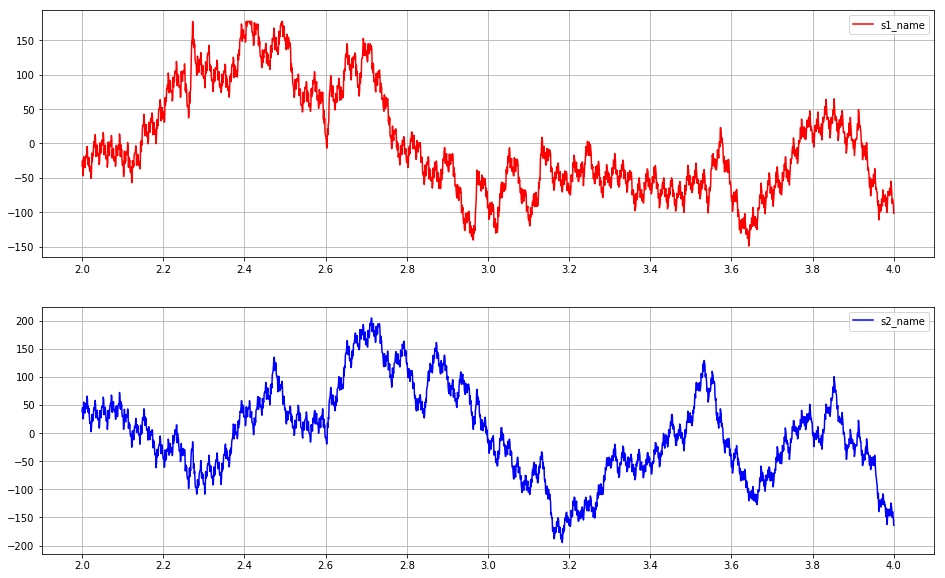

In [8]:
plot_s(s56_24,"s56_24",s62_24,"s62_24",2,4)

In [158]:
s1_56_57_02=record[56][:2000]-record[57][:2000]  # x
s1_66_67_02=record[66][:2000]-record[67][:2000]   #Y

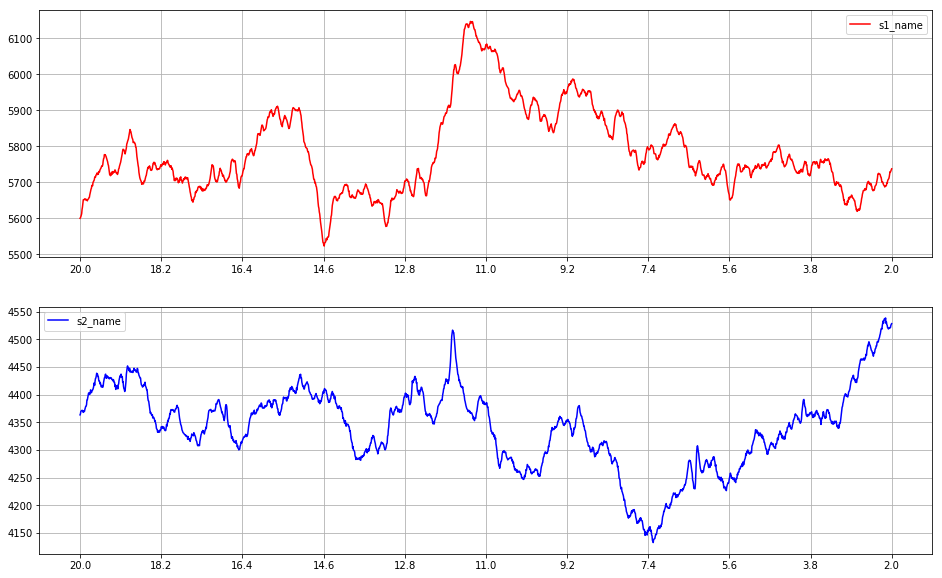

In [72]:
plot_s(s1_56_57_02,"s56_24",s1_66_67_02,"s62_24",20,2)

In [160]:
means1_56_57_02,means1_66_67_02=np.mean(s1_56_57_02),np.mean(s1_66_67_02)
s1_56_57_02,s1_66_67_02=s1_56_57_02-means1_56_57_02,s1_66_67_02-means1_66_67_02
'''

means1_56_57_02,means1_66_67_02=np.mean(s1_56_57_02),np.mean(s1_66_67_02)
s1_56_57_02,s1_66_67_02=s1_56_57_02-means1_56_57_02,s1_66_67_02-means1_66_67_02
'''
np.mean(s1_56_57_02),np.mean(s1_66_67_02)

(-4.2018655221909287e-13, 3.2741809263825414e-14)

In [159]:
signals = np.array([s1_56_57_02,s1_66_67_02])
np.mean(signals[0]),np.mean(signals[1])
setSignaltoZero(signals,1)
np.mean(signals[0]),np.mean(signals[1])

(-4.2018655221909287e-13, 3.2741809263825414e-14)

In [96]:
np.array([s1_56_57_02]).shape,s1_56_57_02.shape

((1, 1999), (1999,))

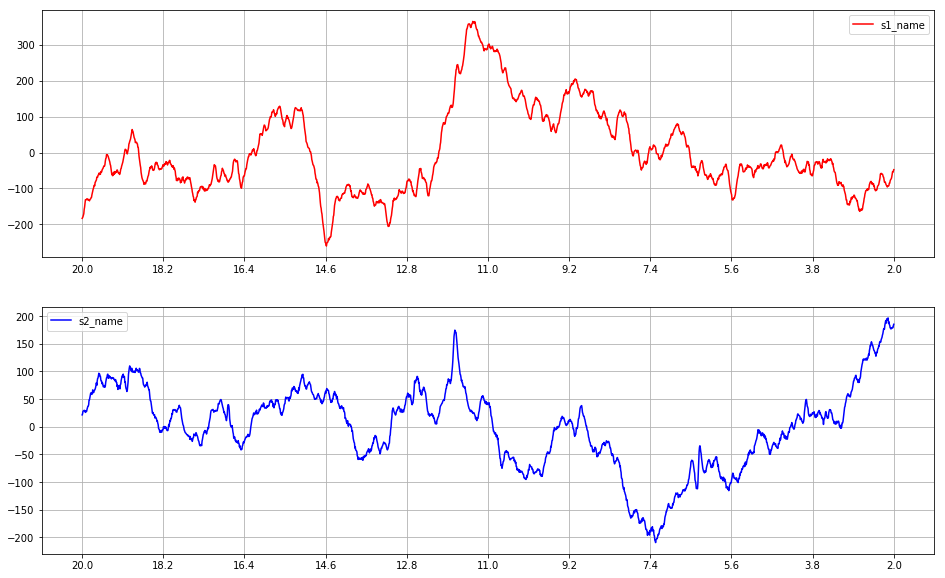

In [35]:
plot_s(s1_56_57_02,"s56_24",s1_66_67_02,"s62_24",20,2)

[0.08579327437157436, 0.01530710247280076]

In [119]:
h2_value4= H2_xy(s1_66_67_02,s1_56_57_02,7)
h2_value4

0.015245450015031303

In [164]:
h2_value1

[array([[0.        , 0.15986207, 0.13868879],
        [0.2074735 , 0.        , 0.22170049],
        [0.50929715, 0.20513468, 0.        ]]),
 array([[0.        , 0.43111137, 0.40847408],
        [0.29032282, 0.        , 0.47428204],
        [0.62752117, 0.46923279, 0.        ]])]

In [157]:
h2_value3,lag_value3= H2_whole(signals2,0,4,1000,slideWindow=2,step=1,maxlag=0.001,L=7)
h2_value3

[array([[0.        , 0.08579327],
        [0.0153071 , 0.        ]]), array([[0.        , 0.43171101],
        [0.44745945, 0.        ]])]

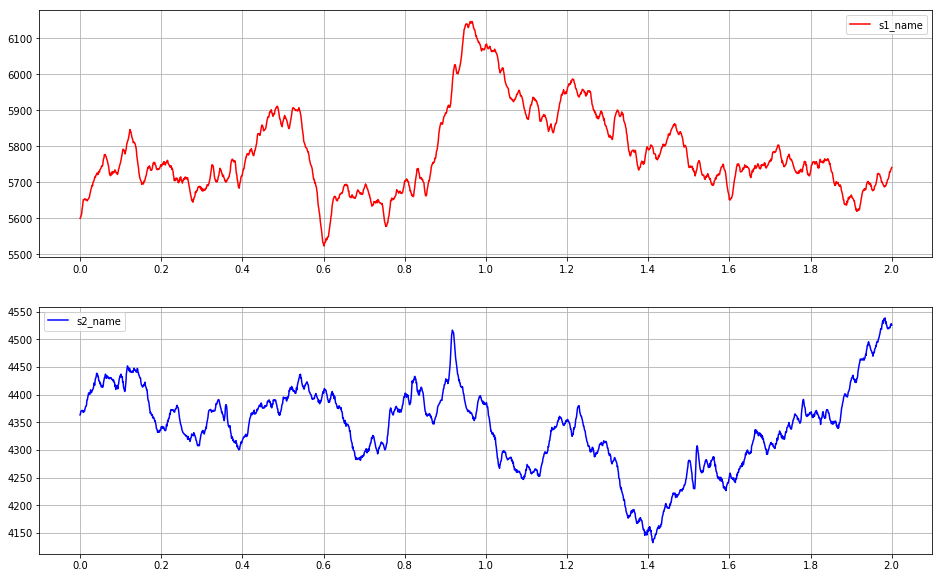

In [170]:
signals2 = np.array([record[56]-record[57],record[66]-record[67]])
plot_s(signals2[0][:2000],"s56_57",signals2[1][:2000],"s66_67",0,2)

In [171]:
h2_value5,lag_value5= H2_whole(signals2,0,4,1000,slideWindow=2,step=1,maxlag=0.001,L=7)
h2_value5

[array([[0.        , 0.08579327],
        [0.0153071 , 0.        ]]), array([[0.        , 0.43171101],
        [0.44745945, 0.        ]])]

In [146]:
signals2 = np.array([record[56]-record[57],record[66]-record[67]])
h2_value2,lag_value2 = H2_whole(signals2,0,4,1000,slideWindow=2,step=1,maxlag=0.1,L=7)
h2_value2

[array([[0.        , 0.22170049],
        [0.20513468, 0.        ]]), array([[0.        , 0.47428204],
        [0.46923279, 0.        ]])]

In [172]:
signals1 = np.array([record[46]-record[47],record[56]-record[57],record[66]-record[67]])
print(signals1.shape)
h2_value6,lag_value6 = H2_whole(signals1,0,4,1000,slideWindow=2,step=1,maxlag=0.1,L=7)

(3, 1322090)


In [173]:
h2_value6

[array([[0.        , 0.15986207, 0.13868879],
        [0.2074735 , 0.        , 0.22170049],
        [0.50929715, 0.20513468, 0.        ]]),
 array([[0.        , 0.43111137, 0.40847408],
        [0.29032282, 0.        , 0.47428204],
        [0.62752117, 0.46923279, 0.        ]])]

In [174]:
lag_value6

[array([[  0.,  69., -15.],
        [-73.,   0., -99.],
        [ 99.,  99.,   0.]]), array([[  0., -92., -99.],
        [ 56.,   0., -45.],
        [ 99.,  19.,   0.]])]

In [175]:
lag_value1

[array([[  0.,  69., -15.],
        [-73.,   0., -99.],
        [ 99.,  99.,   0.]]), array([[  0., -92., -99.],
        [ 56.,   0., -45.],
        [ 99.,  19.,   0.]])]

In [138]:
h2_value1

[array([[0.        , 0.15986207, 0.13868879],
        [0.2074735 , 0.        , 0.22170049],
        [0.50929715, 0.20513468, 0.        ]]),
 array([[0.        , 0.43111137, 0.40847408],
        [0.29032282, 0.        , 0.47428204],
        [0.62752117, 0.46923279, 0.        ]])]

In [142]:
print(lag_value1[0],'\n',lag_value1[1])

[[  0.  69. -15.]
 [-73.   0. -99.]
 [ 99.  99.   0.]] 
 [[  0. -92. -99.]
 [ 56.   0. -45.]
 [ 99.  19.   0.]]


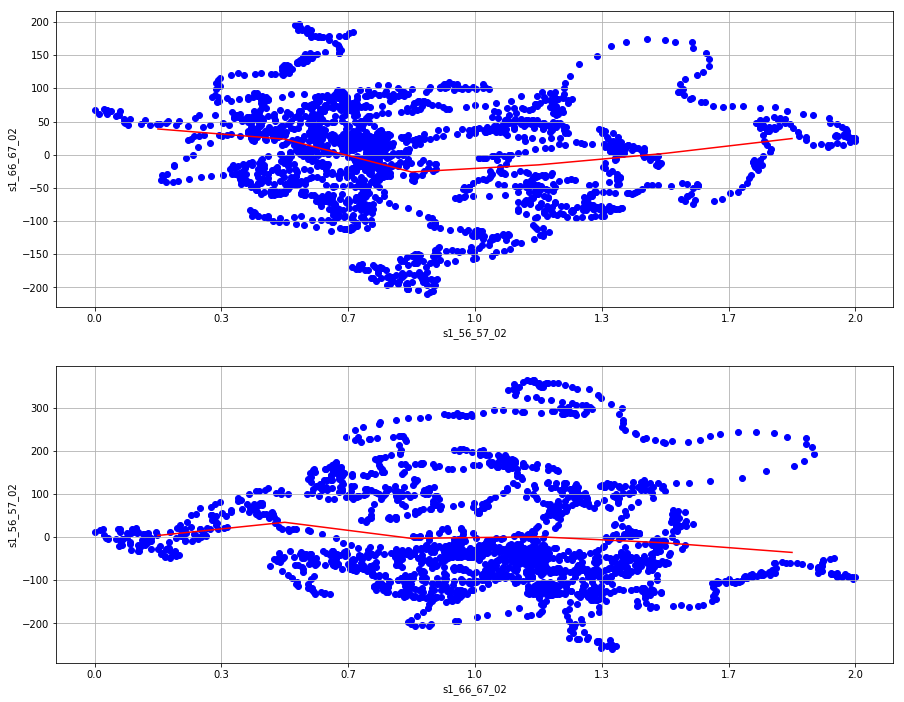

In [60]:
scatter_h2(s1_56_57_02,"s1_56_57_02",s1_66_67_02,"s1_66_67_02",0,2,7,PQ3)

In [22]:
h2_value,PQ = H2(s56_24,s62_24,7)
h2_value

array([[0.        , 0.18265695],
       [0.19659074, 0.        ]])

In [10]:
h2_value,PQ = H2(s56_24,s56_24,7)
h2_value

array([[0.        , 0.99805646],
       [0.99805646, 0.        ]])

In [12]:
h2_value2,PQ2 = H2(s56_24[len(s56_24)//4:],s62_24[len(s56_24)//4:],7)
h2_value2

array([[0.        , 0.32341857],
       [0.44144419, 0.        ]])

In [42]:
h2_02,PQ_02 = H2(s56_02,s62_02,7)
h2_02

array([[0.        , 0.2711559 ],
       [0.24775251, 0.        ]])

In [ ]:
def dichotomy_update(sx,sy,sign,start,stop,new3,old3,old3_h2_value,L=7):
    '''
    new3：新的左中右
    old3：旧的左中右
    old3_h2_value：旧的左中右h2值
    它们都是长度为3的数组
    返回最大h2值及其索引（左中右）值
    '''
    h2_value=[]
    if new3[0]==old3[0]:
        h2_value.append(old3_h2_value[0])
    else:
        if sign>0: # 说明sx向右移
            h2_value.append(H2_xy(sx[start+new3[0]:stop+new3[0]],sy[start:stop],L=7))
        else:
            h2_value.append(H2_xy(sx[start:stop],sy[start+new3[0]:stop+new3[0]],L=7))
        
    if new3[1]==old3[1]:
        h2_value.append(old3_h2_value[1])
    else:
        if sign>0: # 说明sx向右移
            h2_value.append(H2_xy(sx[start+new3[1]:stop+new3[1]],sy[start:stop],L=7))
        else:
            h2_value.append(H2_xy(sx[start:stop],sy[start+new3[1]:stop+new3[1]],L=7))
        
    if new3[2]==old3[2]:
        h2_value.append(old3_h2_value[2])
    else:
        if sign>0: # 说明sx向右移
            h2_value.append(H2_xy(sx[start+new3[2]:stop+new3[2]],sy[start:stop],L=7))
        else:
            h2_value.append(H2_xy(sx[start:stop],sy[start+new3[2]:stop+new3[2]],L=7))
            
    t_h2 = max(h2_value)
    t_index = h2_value.index(t_h2)
    
    
    if t0_index: # 如果 t0_index>0,说明0除不是最大值
        two_signals_h2[0] = t0_h2_max
        if t0_index <= 2:
            two_signals_lag[0] = ((-1)**t0_index)*median
            new_left = (median+left)//2
            new_median = median
            new_right = (median+right)//2

        else:
            two_signals_lag[0] = ((-1)**t0_index)*right
            new_left = median
            new_median = (median+right)//2
            new_right = right
    else:
        new_left = left
        new_median = (median+left)//2
        new_right = median
    

In [ ]:
def H2_whole_dichotomy2(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7):
    '''
    版本6：不求平均,lag算法改进,采用二分法计算最大h2，初始采用7点采样（而不是三点）
    signals：原始信号，numpy矩阵类型（二维矩阵）
    slideWindows:滑动窗口
    duration：信号的持续时间
    '''
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    if maxlag <= 0:
        print("Time maxlag must be greater than zero!")
        
    h2_value = []
    lag_value = []
    dict_sample = dict()
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = int(start_time_window*sampleFreq)
        stop_samples = int(stop_time_window*sampleFreq)
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            s1 = signals[si1][start_samples:stop_samples]
            # [s1] = setSignaltoZero([signals[si1][start_samples:stop_samples]]) # 做归0处理
            
            for si2 in range(si1+1,signals_num):
                s2 = signals[si2][start_samples:stop_samples]
                #[s2] = setSignaltoZero([signals[si2][start_samples:stop_samples]])
                
                # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                
                h2_00 = H2(s1,s2,L)
                
                two_signals_h2[0] = h2_00[0]
                two_signals_h2[1] = h2_00[1]
                # 考虑时间延迟
                # 计算x到y
                
                maxlag_points = int(maxlag*sampleFreq) # 总共样本点
                sample_num = round(maxlag_points**0.5-maxlag_points**0.25)
                if sample_num < 3:
                    sample_num = 3
                sample_points = np.percentile(range(0,maxlag_points),np.linspace(0,100,sample_num),interpolation='nearest')
                
                t0_h2 = []
                t1_h2 = []
                dict_sample.clear()
                sign = 1 # 符号位，判断是x移动还是y移动
                left = right = new_left = new_median = new_right = 0
                
                for tagi in sample_points[1:]: # x向右移动，符号为正；y向右移动，符号为负
                    
                    s1m = signals[si1][start_samples+tagi:stop_samples+tagi]
                    s2m = signals[si2][start_samples+tagi:stop_samples+tagi]

                    h2_mn = H2(s1m,s2,L) # s1向右移
                    h2_nm = H2(s1,s2m,L) # s2向右移

                    t0_h2.extend([h2_mn[0],h2_nm[0]])
                    t1_h2.extend([h2_mn[1],h2_nm[1]])
                
                t0_h2_max = max(t0_h2)
                t1_h2_max = max(t1_h2)
                
                t0_index = t0_h2.index(t0_h2_max)
                t1_index = t1_h2.index(t1_h2_max)
                
                sign = (-1)**t0_index
                if t0_h2_max>two_signals_h2[0]:
                    two_signals_h2[0] = t0_h2_max
                    sub1_h2 = index//2 + 1
                    two_signals_lag[0] = sign*sample_points[sub1_h2]
                    if sub1_h2 < (sample_num - 1):
                        left = sample_points[sub1_h2-1]
                        right = sample_points[sub1_h2+1]
                        new_median = sample_points[sub1_h2]
                        new_left = (left+new_median)//2
                        new_right = (right+new_median)//2
                        #dict_sample[left] = t0_h2[t0_index-2]
                        dict_sample[new_median] = t0_h2[t0_index]
                        #dict_sample[right] = t0_h2[t0_index+2]
                    else:
                        left = sample_points[sub1_h2-2]
                        new_right = right = sample_points[sub1_h2]
                        new_median = (sample_points[sub1_h2]+sample_points[sub1_h2-1])//2
                        new_left = (sample_points[sub1_h2-1]+sample_points[sub1_h2-2])//2
                        dict_sample[sample_points[sub1_h2-1]] = t0_h2[t0_index-2]
                        dict_sample[right] = t0_h2[t0_index]
                else:
                    right = sample_points[2]
                    new_left = left = 0
                    new_right = (right+sample_points[1])//2
                    new_median = sample_points[1]//2
                    dict_sample[sample_points[1]] = t0_h2[(1-sign)//2]
                    dict_sample[0] = two_signals_h2[0]
                
                print(sign)
                while (new_right-new_left) > 2:
                    t0_h2 = []
                    if dict_sample.get(new_left):
                        t0_h2.append(dict_sample[new_left])
                    else:
                        if sign>0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_left:stop_samples+new_left]
                            t0_h2.append(H2_xy(sxx,s2,L))
                        else:
                            syy = signals[si2][start_samples+new_left:stop_samples+new_left]
                            t0_h2.append(H2_xy(s1,syy,L))
                        dict_sample[new_left] = t0_h2[0]
                            
                    if dict_sample.get(new_median):
                        t0_h2.append(dict_sample[new_median])
                    else:
                        if sign>0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_median:stop_samples+new_median]
                            t0_h2.append(H2_xy(sxx,s2,L))
                        else:
                            syy = signals[si2][start_samples+new_median:stop_samples+new_median]
                            t0_h2.append(H2_xy(s1,syy,L))
                        dict_sample[new_median] = t0_h2[1]
                        
                    if dict_sample.get(new_right):
                        t0_h2.append(dict_sample[new_right])
                    else:
                        if sign>0: # 说明sx向右移
                            sxx = signals[si1][start_samples+new_right:stop_samples+new_right]
                            t0_h2.append(H2_xy(sxx,s2,L))
                        else:
                            syy = signals[si2][start_samples+new_right:stop_samples+new_right]
                            t0_h2.append(H2_xy(s1,syy,L))
                        dict_sample[new_right] = t0_h2[2]
                            
                    two_signals_h2[0] = max(t0_h2)
                    t0_index = t0_h2.index(two_signals_h2[0])
                    
                    if t0_index == 1:
                        two_signals_lag[0] = sign*new_median
                        left = new_left
                        right = new_right
                        new_left = (new_left+new_median)//2
                        new_right = (new_median+new_right)//2
                    elif t0_index == 0:
                        two_signals_lag[0] = sign*new_left
                        if left==new_left:
                            right = new_right = new_median
                            new_median = (new_right+new_left)//2
                        else:
                            right = new_median
                            new_right = (new_median+new_left)//2
                            new_median = new_left
                            new_left = (left+new_left)//2
                    else:
                        two_signals_lag[0] = sign*new_right
                        if right==new_right:
                            left = new_left = new_median
                            new_median = (new_right+new_left)//2
                        else:
                            left = new_median
                            new_left = (new_median+new_right)//2
                            new_median = new_right
                            new_right = (new_right+right)//2
                            
                    print(t0_index,left,right,new_left,new_median,new_right)        
                print(dict_sample)
                
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    #print(time_flexity)
    return h2_value,lag_value